# The CBacktester Class

## Import libraries and packages

In [7]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
import seaborn as sns
plt.style.use('seaborn')

## Build CBacktester

In [153]:
class CBacktester():
    '''This is a docstring'''
    def __init__(self, filepath, symbol, start, end, tc):
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.dev = 2
        self.sma = 20
        self.data = None
        self.results = None
        self.get_data()
        self.td_year = (self.data.price.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "CBacktester: symbol = {}, start = {}, end = {}, ptc = {}".\
        format(self.symbol, self.start, self.end, self.tc)
        
    def get_data(self):
        raw = pd.read_csv(self.filepath, parse_dates=['time'], index_col='time')
        raw = raw[self.symbol].to_frame().fillna(method = 'ffill')
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol:'price'}, inplace=True)
        raw['returns'] = np.log(raw.price / raw.price.shift(1))
        self.data = raw
    
    def upsample(self): #review this method
        data = self.data.copy()
        resamp = self.results.copy()
        
        data['position'] = resamp.position.shift(1) #review: not sure why this is being called
        data = data.loc[data.index[0]:].copy()
        data.position = data.position.shift(-1).ffill() #review: not sure why this is being called
        data.dropna(inplace=True)
        self.results = data
    
    def prepare_data(self, freq, sma, dev):
        data = self.data.price.to_frame().copy()
        freq = "{}min".format(freq)
        self.sma = sma
        self.dev = dev
        #resample() requires an agg method, such as last(), first(), mean(), etc
        resamp = data.resample(freq).last().dropna().iloc[:-1] #the last bar is incomplete, so drop it
        resamp['returns'] = np.log(resamp/resamp.shift(1)) #take returns on the resampled data
        #resamp['roll_return'] = resamp['returns'].rolling(window).mean()
        #resamp['position'] = -np.sign(resamp['roll_return'])
        ##############
        ###############
        ###############
        
        resamp["sma"] = resamp.price.rolling(self.sma).mean()
        resamp.dropna(inplace=True)
        resamp["Lower"] = resamp["sma"] - resamp.price.rolling(self.sma).std() * self.dev
        resamp["Upper"] = resamp["sma"] + resamp.price.rolling(self.sma).std() * self.dev
        #return resamp
        resamp["distance"] = resamp.price - resamp.sma
        resamp["position"] = np.where(resamp.price < resamp.Lower, 1, np.nan)
        resamp["position"] = np.where(resamp.price > resamp.Upper, -1, resamp["position"])
        resamp["position"] = np.where(resamp.distance * resamp.distance.shift(1) < 0, 0, resamp["position"])
        resamp["position"] = resamp.position.ffill().fillna(0)
        ##############
        ###############
        ###############
        resamp.dropna(inplace=True)
        self.results = resamp
        return resamp

    def run_backtest(self):
        data = self.results.copy()
        data['strategy'] = data['position'].shift(1) * data['returns']
        
        data['trades'] = data.position.diff().fillna(0).abs() #finds the difference between the rows in 'position'
        data['ctrades'] = data.trades.cumsum()
        data.strategy = data.strategy - data['trades'] * self.tc #subtract trading costs from strategy
        self.results = data       
    
    def test_strategy(self, freq = 60, sma = 20, dev = 2):
        self.freq = "{}".format(freq)
        self.sma = sma
        self.dev = dev
        #print(self.sma)
        #return
        self.prepare_data(freq,int(sma),dev)
        self.upsample()
        self.run_backtest()
        
        data = self.results.copy()
        data['creturns'] = data['returns'].cumsum().apply(np.exp)
        data['cstrategy'] = data['strategy'].cumsum().apply(np.exp)
        self.results = data
          
    def plot_results(self, leverage = False):
        if self.results is None:
            print('run test_strategy() first')
            return
        elif leverage:
            self.results[['creturns', 'cstrategy', 'cstrategy_levered']].plot(logy=False, figsize=(15,8),\
            title = '{} | Frequency: {} | SMA: {} | DEV: {} | TC: {:.6f} | Leverage: {:.2f}'.\
            format(self.symbol, self.freq, self.sma, self.dev, round(self.tc,6), self.leverage))
        else:    
            self.results[['creturns', 'cstrategy']].plot(logy=False, figsize=(15,8),\
            title = '{} | Frequency: {} | SMA: {} | DEV: {} | TC: {}'.\
            format(self.symbol, self.freq, self.sma, self.dev, round(self.tc,6)))
            
    def optimize_strategy(self, freq_range, sma_range, dev_range,  metric = "Multiple"):
        
        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        elif metric == "Sortino":
            performance_function = self.calculate_sortino
        elif metric == "Calmar": 
            performance_function = self.calculate_calmar
        elif metric == "Kelly": 
            performance_function = self.calculate_kelly_criterion
        
        
        performance = []
        i = 0
        freqs = range(*freq_range)
        smas = range(*sma_range)
        #return np.linspace(*dev_range) #############################################################################
        devs = np.linspace(*dev_range)
        combinations = list(product(freqs, smas, devs))
        
        for comb in combinations:
            clear_output(wait=True)
            display('Optimization in progress... Iteration {} of {}. Testing: freq = {}, sma = {}, dev = {}'.\
                    format(i, len(combinations), comb[0], comb[1], comb[2]))
            self.test_strategy(comb[0], comb[1], comb[2])
            self.upsample() #review: not sure why this is being called
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
            i += 1
            
        self.results_overview = pd.DataFrame(data = np.array(combinations), columns = ['Freq', 'Sma', 'Dev'])
        self.results_overview['Performance'] = performance
         
        self.find_best_strategy()
            
    
    def find_best_strategy(self):
        self.best = self.results_overview.nlargest(1, "Performance")
        freq = self.best.Freq.iloc[0]
        sma = self.best.Sma.iloc[0]
        dev = self.best.Dev.iloc[0]
        perf = self.best.Performance.iloc[0]
        clear_output(wait=True) #clear output again after last iteration
        print(100 * "=")
        print('BEST COMBINATION: FREQUENCY = {}-MINUTE CHART | SMA = {} | DEV = {} | {} = {}'.format(freq, sma, dev, 'Multiple', round(perf,6)))
        print(100 * "-")
        print("\n")
        
        self.test_strategy(freq, sma, dev)
        
    def visualize_many(self):
        if self.results is None:
            print('Run test_strategy() first.')
        else:
            matrix = self.results_overview.pivot_table(index='Dev', columns='Sma', values='Performance', aggfunc='max')
            plt.figure(figsize=(15,8))
            sns.set_theme(font_scale=1.5)
            sns.heatmap(matrix, cmap = 'RdYlGn', robust=True, cbar_kws = {"label":'{}'.format(self.metric)})
            plt.show()
            
            
    def add_sessions(self, visualize = False):
        data = self.results.copy()
        
        data['session'] = np.sign(data.trades).cumsum().shift(1).fillna(0)
        
        #cumulative log returns per trading session
        data['logr_session'] = data.groupby('session').strategy.cumsum() 
        
        #cumulative simple returns per trading session
        data['session_compound'] = data.groupby('session').strategy.cumsum().apply(np.exp) - 1
        
        self.results = data
        
        if visualize:
            data['session_compound'].plot(figsize=(12,8))
            plt.show()
        
        
    def add_stop_loss(self, sl_thresh, report = True):
        self.sl_thresh = sl_thresh
        
        if self.results is None:
            print('Run test_strategy() first.')
        
        self.add_sessions()
        self.results = self.results.groupby('session').apply(self.define_sl_pos)
        self.run_backtest()
        data = self.results.copy()
        data['creturns'] = data['returns'].cumsum().apply(np.exp)
        data['cstrategy'] = data['strategy'].cumsum().apply(np.exp)
        self.results = data
        self.add_sessions(report)
        
        if report:
            self.print_performance()
        
    
    def add_take_profit(self, tp_thresh, report = True):
        self.tp_thresh = tp_thresh
        
        if self.results is None:
            print('Run test_strategy() first.')
        
        self.add_sessions()
        self.results = self.results.groupby('session').apply(self.define_tp_pos)
        self.run_backtest()
        data = self.results.copy()
        data['creturns'] = data['returns'].cumsum().apply(np.exp)
        data['cstrategy'] = data['strategy'].cumsum().apply(np.exp)
        self.results = data
        self.add_sessions(report)
        
        if report:
            self.print_performance()
    
    def define_sl_pos(self, group):
        if (group.session_compound <= self.sl_thresh).any():
            start = group[group.session_compound <= self.sl_thresh].index[0]
            stop = group.index[-2]
            group.loc[start:stop, 'position'] = 0
            return group
        else:
            return group
    
    def define_tp_pos(self, group):
        if (group.session_compound >= self.tp_thresh).any():
            start = group[group.session_compound >= self.tp_thresh].index[0]
            stop = group.index[-2]
            group.loc[start:stop, 'position'] = 0
            return group
        else:
            return group
    
    def add_leverage(self, leverage, sl = -0.5, report = True):
        self.leverage = leverage
        sl_thresh = sl / leverage #remember, leverage multiplies losses, so you must cut the sl!
        
        self.add_stop_loss(sl_thresh, report = False)
        
        data = self.results.copy()
        data['simple_ret'] = np.exp(data.strategy) - 1 
        data['eff_lev'] = leverage * (1 + data.session_compound) / (1 + data.session_compound * leverage)
        data.eff_lev.fillna(leverage, inplace=True)
        data.loc[data.trades != 0, 'eff_lev'] = leverage
        levered_returns = data.eff_lev.shift() * data.simple_ret
        levered_returns = np.where(levered_returns < -1, -1, levered_returns)
        data['strategy_levered'] = levered_returns
        data['cstrategy_levered'] = data.strategy_levered.add(1).cumprod()
        self.results = data
        
        if report:
            self.print_performance(leverage = True)
        
    
    def print_performance(self, leverage = False):
        data = self.results.copy()
        
        if leverage:
            to_analyze = np.log(data.strategy_levered.add(1))
        else:
            to_analyze = data.strategy
        
        bh_multiple =               round(self.calculate_multiple(data.returns),6)
        strategy_multiple =         round(self.calculate_multiple(to_analyze),6)
        strategy_cagr =             round(self.calculate_cagr(to_analyze),6)
        outperf =                   round(strategy_multiple - bh_multiple, 6)
        strategy_ann_mean =         round(self.calculate_annulized_mean(to_analyze),6)
        strategy_ann_std =          round(self.calculate_annulized_std(to_analyze),6)
        strategy_sharpe =           round(self.calculate_sharpe(to_analyze),6)
        strategy_sortino =          round(self.calculate_sortino(to_analyze),6)
        strategy_max_dd =           round(self.calculate_max_drawdown(to_analyze),6)
        strategy_calmar =           round(self.calculate_calmar(to_analyze),6)
        strategy_max_dd_dur =       round(self.calculate_max_dd_duration(to_analyze),6)
        strategy_kelly =            round(self.calculate_kelly_criterion(to_analyze),6)
        
        print(100 * "=")
        print("SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = {} | FREQ = {} | SMA = {} | DEV = {}".format(self.symbol, self.freq, self.sma, self.dev))
        print(100 * "-")
        print("\n")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {:,.6f}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {:,.6f}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {:,.6f}".format(outperf))
        print("\n")
        print("CAGR:                        {:,.6f}".format(strategy_cagr))
        print("Annualized Mean:             {:,.6f}".format(strategy_ann_mean))
        print("Annualized Std:              {:,.6f}".format(strategy_ann_std))
        print("Sharpe Ratio:                {:,.6f}".format(strategy_sharpe))
        print("Sortino Ratio:               {:,.6f}".format(strategy_sortino))
        print("Maximum Drawdown:            {:,.6f}".format(strategy_max_dd))
        print("Calmar Ratio:                {:,.6f}".format(strategy_calmar))
        print("Max Drawdown Duration:       {} Days".format(strategy_max_dd_dur))
        print("Kelly Criterion:             {:,.6f}".format(strategy_kelly))
        
        print(100 * "=")
        
    
    def calculate_multiple(self, series):
        #return series.iloc[-1]/series.iloc[0] #this returns multiple if the series is PRICE data
        return np.exp(series.sum()) #returns muliple if the series is log returns (does work with nan in 0 pos)
        #return series.cumsum().apply(np.exp).iloc[-1]
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annulized_mean(self, series):
        return series.mean() * self.td_year
    
    def calculate_annulized_std(self, series):
        return series.std() * np.sqrt(self.td_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return series.mean() / series.std() * np.sqrt(self.td_year)
    
    def calculate_sortino(self, series):
        excess_returns = (series - 0)
        downside_deviation = np.sqrt(np.mean(np.where(excess_returns < 0, excess_returns, 0)**2))
        if downside_deviation == 0:
            return np.nan
        else:
            sortino = (series.mean() - 0) / downside_deviation * np.sqrt(self.td_year)
            return sortino 
    
    def calculate_max_drawdown(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
        max_dd = drawdown.max()
        return max_dd
    
    def calculate_calmar(self, series):
        max_dd = self.calculate_max_drawdown(series)
        if max_dd == 0:
            return np.nan
        else:
            cagr = self.calculate_cagr(series)
            calmar = cagr / max_dd
            return calmar
    
    def calculate_max_dd_duration(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
    
        begin = drawdown[drawdown == 0].index
        end = begin[1:]
        end = end.append(pd.DatetimeIndex([drawdown.index[-1]]))
        periods = end - begin
        max_ddd = periods.max()
        return max_ddd.days
    
    def calculate_kelly_criterion(self, series):
        series = np.exp(series) - 1
        if series.var() == 0:
            return np.nan
        else:
            return series.mean() / series.var()

## CBacktester in Use

In [186]:
spread = 1.4
pips = 0.0001

tester = CBacktester("one_minute.csv", "EURUSD", "2018-01-01", "2019-12-31", spread*pips/2) #mult by 2 for a 'round trip', multiply by pips

tester.prepare_data(freq = 60, sma = 20, dev = 2)

##test strategy as a speicifc window and freq
tester.test_strategy(freq = 60, sma = 20, dev = 2)


##optimize for a given metric
tester.optimize_strategy((1,400,24),(25,200,12),(1,3,18), metric = "Multiple") #full
#tester.optimize_strategy((1,400,200),(1,200,100),(1,5,2), metric = "Multiple") #quick

##show all tested combinations (this must be commented out if optimize_strategy is commented out)
#tester.visualize_many()

#add SL to tester object
#tester.add_stop_loss(-0.005, True)

#add TP to tester object
#tester.add_take_profit(0.005, True)

#add half kelly leverage
#half_kelly = (tester.calculate_kelly_criterion(tester.results.strategy))/2
#tester.add_leverage(leverage = half_kelly, sl = -0.35)

#plot results and print performance
#tester.plot_results(leverage = True)

BEST COMBINATION: FREQUENCY = 361.0-MINUTE CHART | SMA = 49.0 | DEV = 1.7058823529411764 | Multiple = 1.280781
----------------------------------------------------------------------------------------------------




In [187]:
tester.results_overview.pivot_table(index='Freq', columns='Sma', values='Performance', aggfunc='max')

Sma,25.0,37.0,49.0,61.0,73.0,85.0,97.0,109.0,121.0,133.0,145.0,157.0,169.0,181.0,193.0
Freq,,,,,,,,,,,,,,,
1.0,0.614783,0.648382,0.659984,0.686074,0.733910,0.762512,0.770740,0.790024,0.806683,0.833175,0.854208,0.873069,0.896214,0.889381,0.876331
25.0,1.059544,1.016995,1.015897,1.037488,1.029497,1.003219,1.003278,1.015937,1.015197,1.001547,0.996242,0.994425,0.940620,0.960353,0.981830
49.0,1.003851,1.065489,1.013396,1.034272,1.018270,0.988852,0.979501,0.992921,0.972204,0.987439,1.013391,1.040882,1.068392,1.108322,1.128532
73.0,1.001250,1.011702,1.012826,0.963934,0.988703,0.978504,1.017755,1.051904,1.099040,1.118545,1.088265,1.093285,1.105124,1.139660,1.160700
97.0,1.026881,1.016648,0.975923,1.005287,1.012776,1.076862,1.116008,1.119335,1.115120,1.149020,1.183639,1.187213,1.211385,1.226496,1.246288
121.0,1.041150,0.986442,0.989267,1.036177,1.073817,1.085567,1.105896,1.132155,1.196792,1.241855,1.245398,1.252659,1.262744,1.247594,1.242794
145.0,1.011117,1.018510,1.027589,1.082999,1.091684,1.116705,1.166300,1.209067,1.249790,1.234355,1.243603,1.243678,1.221641,1.213705,1.193407
169.0,1.018359,0.990482,1.058820,1.097277,1.119338,1.165705,1.208638,1.231841,1.251410,1.235456,1.199287,1.192290,1.185597,1.198006,1.162639
193.0,1.007505,1.027296,1.101101,1.102506,1.187457,1.221920,1.223467,1.224203,1.210169,1.208379,1.211087,1.195276,1.180517,1.164186,1.172410


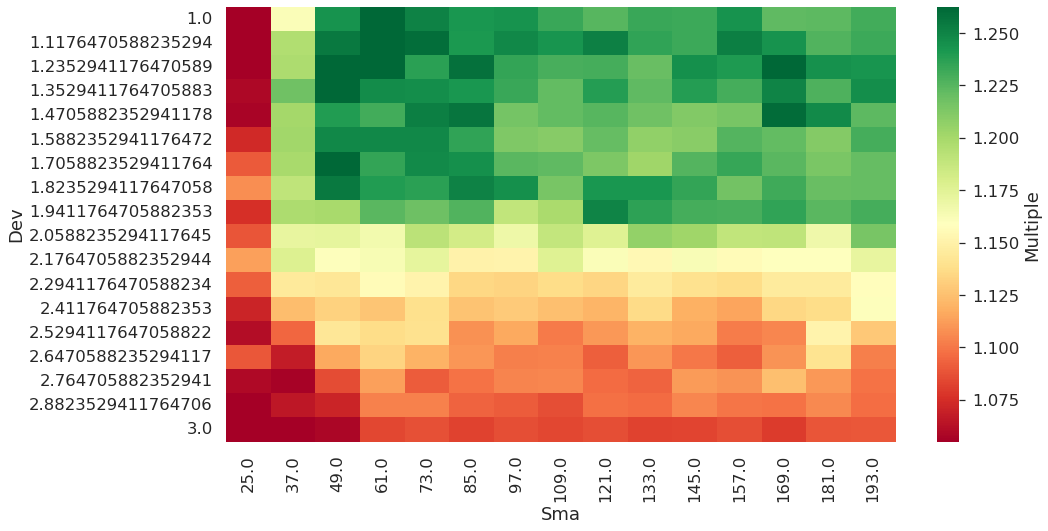

In [188]:
##show all tested combinations (this must be commented out if optimize_strategy is commented out)
tester.visualize_many()

#add SL to tester object
#tester.add_stop_loss(-0.005, True)

#add TP to tester object
#tester.add_take_profit(0.005, True)

SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | FREQ = 361.0 | SMA = 49 | DEV = 1.7058823529411764
----------------------------------------------------------------------------------------------------


PERFORMANCE MEASURES:


Multiple (Strategy):         195.390982
Multiple (Buy-and-Hold):     0.896314
--------------------------------------
Out-/Underperformance:       194.494668


CAGR:                        14.930564
Annualized Mean:             2.771689
Annualized Std:              1.258116
Sharpe Ratio:                2.203047
Sortino Ratio:               3.144389
Maximum Drawdown:            0.612140
Calmar Ratio:                24.390764
Max Drawdown Duration:       197 Days
Kelly Criterion:             2.251164


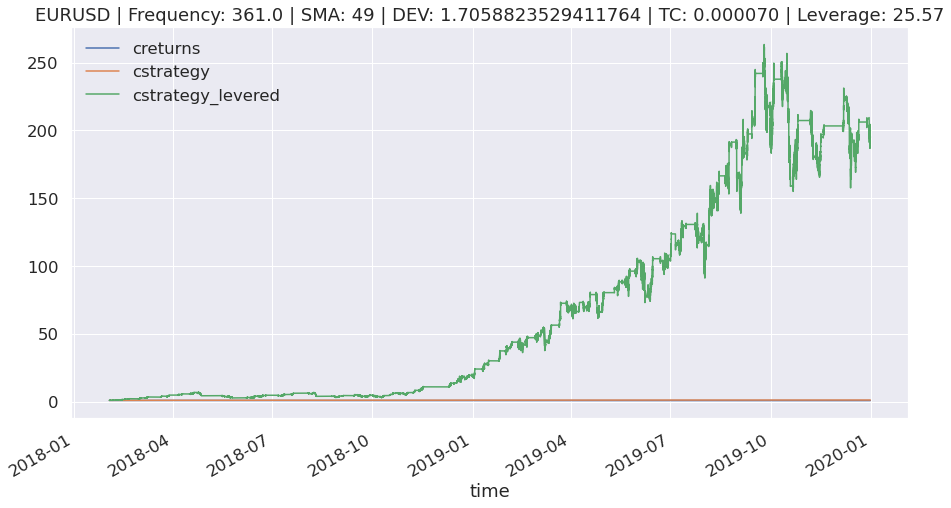

In [189]:
#add half kelly leverage
half_kelly = (tester.calculate_kelly_criterion(tester.results.strategy))/2
tester.add_leverage(leverage = half_kelly, sl = -0.35)

#plot results and print performance
tester.plot_results(leverage = True)

## Utility: Find number of combinations

In [181]:
#(1,400,24),(1,200,24),(1,3,9)
freqs = range(1,400,24)
smas = range(1,200,24)
#return np.linspace(*dev_range) #############################################################################
devs = np.linspace(1,3,9)
combinations = list(product(freqs, smas, devs))
len(combinations)

1377

In [201]:
tester.results_overview[tester.results_overview.Freq == 49+24+24].sort_values(by="Performance", ascending=False)

,Freq,Sma,Dev,Performance
1335,97.0,193.0,1.352941,1.246288
1334,97.0,193.0,1.235294,1.240821
1333,97.0,193.0,1.117647,1.232424
1332,97.0,193.0,1.000000,1.230850
1340,97.0,193.0,1.941176,1.230166
...,...,...,...,...
1085,97.0,25.0,1.588235,0.897639
1098,97.0,37.0,1.000000,0.897622
1136,97.0,61.0,1.235294,0.895853
1117,97.0,49.0,1.117647,0.891241
